# INFO 204 Lab 6 - More Cross Validation and Neural Networks

***<span style='color: #ce2227;'>PLEASE READ ALL THE INSTRUCTIONS AND ACCOMPANYING TEXT IN LAB NOTEBOOKS - THE INFORMATION NEDED TO ANSWER A GIVEN TASK OR INTERPRET A GIVEN RESULT IS OFTEN IN THE TEXT!</span>***

In the previous lab, you took the initial steps into using cross validation to identify good hyperparameter and model settings. In this lab, you will:

1. Develop basic functions to further encapsulate the model and hyperparameter evaluation process; and
2. Empirically anlayse the relationship between test set error and cross validation error.

You will do this for two simple problems - a regression problem, and a classification problem.

In addition, this lab provides a brief introduction to learning neural network (deep learning) models in scikit-learn. Neural networks are among the most complex methods in machine learning, and require a large amount of hyperparameter tuning to ensure good model fitting. They are also very computationally expensive to fit, typically requiring parallel computing hardware (e.g., GPUs) to obtain good performance in reasonable time. Finally, neural networks work best when there is a large supply of training data. Long story short: we are only able to scratch the surface of neural networks in this lab, and we'll leave the main discussion of them to lectures.

**Note:** There are only two coding tasks in this lab - the focus in this lab is on interpretation of results. Most tasks will ask you to write a description and/or interpretation of the results of executing the provided code.

## Precursors

In this lab, you will perform a large amount of cross validation. To ensure repeatible and consistent behaviour across all methods, we set up the <code>RepeatedKFolds</code> class here and reuse it throughout the document:

In [1]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1234)

## Regression

In the previous lab, you should have noticed a large amount of repetition in your work - the code to fit and evaluate learning algorithms followed a largely identical framework (i.e., load data, fit a model, obtain predictions, compare predictions to known outcomes and obtain a score/loss). The <code>GridSearchCV</code> class helps to encapsulate this, but the interpretation of handling of cross validation statistics requires follow-up boilerplate code. The every other software development problem, we can simplify our code (as well as reduce code redundancy, and ensure consistency) if we write wrapper functions that will perform the heavy lifting for us.

The following function, <code>cross_validate_model_mse()</code> encapsulates the grid search process from the previous lab (using <code>GridSearchCV</code> class to search the specified hyperparameter combinations for the optimal configuration) and returns the result of search, and a data frame that presents a cleaned-up interpretation of the results:

In [2]:
def cross_validate_model_mse(mdl, param_grid, X, y, cv=None):
    import numpy as np
    import pandas as pd

    from sklearn.metrics import mean_squared_error, make_scorer
    from sklearn.model_selection import GridSearchCV
    
    ## create an MSE scorer to replace the default R2 scorer. As a scorer is required to
    ## be maximised, and MSE is a loss to be minimised, so we set the greater_is_better
    ## argument to False. This means that the score returned will be nagative. At the end
    ## of this function, we will conver the MSE back to a positive value
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    ## perform the grid search on the supplied data
    cv = GridSearchCV(mdl, param_grid, scoring=scorer, cv=cv)
    cv.fit(X, y)

    ## convert the cross validation results into a data frame, keeping only the
    ## hyperparameter columns and the scores from individual runs, then conver the data
    ## frame from wide to long (via melt). After this, clean up the column names and split
    ## information. Finally, convert the MSE value back to positive
    cv_stats = pd.DataFrame(cv.cv_results_).filter(regex='(param_.*)|(split.*_test_score)', axis=1)
    cv_stats = cv_stats.melt(id_vars=cv_stats.columns[cv_stats.columns.str.match('param_.*')], var_name='split', value_name='mse')
    cv_stats.rename(columns=lambda n: n.replace('param_', ''), inplace=True)
    cv_stats['split'] = cv_stats['split'].str.replace('split(\d+)_test_score', '\\1', regex=True).astype(np.int64)
    cv_stats['mse'] = -cv_stats['mse']
    
    return cv, cv_stats

We can also write a function to encapsulate a more traditional training/testing evaluation of the hyperparameter settings. Below, you are asked to implement a function <code>obtain_train_test_mse</code> that takes the following arguments:
1. <code>mdl</code> - the learning algorithm to be examined (e.g., <code>KNearestRegressor</code>)
2. <code>hyperparameter_name</code> - the name of the hyperparameter that you wish to explore
3. <code>hyperparameter_value</code> - the list of values to explore for the learning algorithm
4. <code>X_*</code>, <code>y_*</code> - the training and testing data for our learning and evaluation process
5. <code>runs</code> - the numbers of times to run the training-testing process (default: 1 - change for algorithms with a random element to their behaviour, such as <code>MLPRegressor</code>)
6. <code>progress</code> - optionally use this to implement "progress" bars for the run.

The function implements the following algorithm:
1. Start with an empty "results list" (e.g., res = [])
2. For the required number of runs:
    1. (optional) update the progress bar for the start of this round - YOU DO NOT NEED TO IMPLEMENT THIS
    2. For each val in the hyperparameter values:
        1. call the <code>set_params</code> method of the <code>mdl</code> object, passing in a dictionart of the current parameter and value (in other words, execute: <code>mdl.set_params(**{ hyperparameter_name : val })</code>
        2. fit the model on <code>X_train</code> and <code>y_train</code>
        3. obtain the ***training mean squared error*** of the model
        4. obtain the ***test mean squared error*** of the model
        5. append the following list to the "results list": <code>[ val, training_mse, testing_mse ]</code>
        6. (optional) update the progress bar for the next hyperparameter value - YOU DO NOT NEED TO IMPLEMENT THIS
    3. (optional) update the progress bar for the next round - YOU DO NOT NEED TO IMPLEMENT THIS
3. convert the "results list" into a data frame, using the column names <code>[ hyperparameter_name, 'train', 'test' ]</code>
4. return the results list.

**TASK 1:** Write a function that encapsulates the process of training and testing a learning algorithm over a range of hyperparameter values.

In [14]:
def obtain_train_test_mse(mdl, hyperparameter_name, hyperparameter_values, X_train, y_train, X_test, y_test, runs=1, progress=True):
    from sklearn.metrics import mean_squared_error
    import pandas as pd
    res = []
    for val in hyperparameter_values:
        mdl.set_params(**{hyperparameter_name: val})
        mdl.fit(X_train, y_train)
        training_mse = mean_squared_error(y_train, mdl.predict(X_train))
        testing_mse = mean_squared_error(y_test, mdl.predict(X_test))
        res.append([val, training_mse, testing_mse])
    res = pd.DataFrame(res, columns=[hyperparameter_name, 'train', 'test'])
    return res

With these functions written, we can now proceed with the regression examples. We start with a simple generator for our problem: the underlying generating function for our problem is $f(X) = \left(x_1 - x_2\right)^2 + \sin\left(4\pi{}x_3\right)$ (as usual our learning methods are unaware of the existence of this function and will attempt to learn an adequate surrogate for it instead)

In [17]:
import numpy as np

def make_data(n_instances=100, random_state=None):
    if random_state is None:
        random_state = np.random.default_rng()
    elif isinstance(random_state, int):
        random_state = np.random.default_rng(random_state)
    
    X = random_state.uniform(0, 1, size=(n_instances, 6))
    y = (X[:, 0] - X[:, 1])**2 + np.sin(4 * np.pi * X[:, 2])
    return (X, y + random_state.normal(0, np.std(y) / 3, size=len(y)))

(X_train, y_train), (X_test, y_test) = make_data(250, random_state=1234), make_data(6000, random_state=5678)

Note that we are generating 250 training instances, against 6000 testing instances.

Now, the following code block uses the previously defined functions to examine the behaviour of three learning algorithms (plus a dummy regressor) on our sample problem. ***THIS CODE CELL TAKES A LONG TIME TO EXECUTE (ABOUT 15 MINUTES) - PLEASE BE PATIENT AND ASK A LAB SUPERVISOR TO CONFIRM YOUR WORK IN THE PREVIOUS TASK BEFORE RUNNING THIS!***

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

dr = DummyRegressor(strategy='mean')
dr_grid = {} ## note: the dummy regressor has no real tunable hyperparameters, hence the empty dictionary

CART = DecisionTreeRegressor()
CART_grid = { 'min_samples_split' : [ i for i in range(2, 101) ] }

zknn = Pipeline([ ('scale', StandardScaler()), ('knn', KNeighborsRegressor()) ])
zknn_grid = { 'knn__n_neighbors' : [ i for i in range(1, 101) ] }

nnet = Pipeline([ ('scale', StandardScaler()), ('mlp', MLPRegressor(max_iter=10000)) ])
nnet_grid = { 'mlp__hidden_layer_sizes' : [ 1, 2, 4, 6, 11, 19, 33, 59, 106, 189, 200, 223, 247, 274, 304 ] }

drcv, dr_stats = cross_validate_model_mse(dr, dr_grid, X_train, y_train, cv=rkf)

CART_train_test = obtain_train_test_mse(CART, 'min_samples_split', CART_grid['min_samples_split'], X_train, y_train, X_test, y_test)
CARTcv, CART_stats = cross_validate_model_mse(CART, CART_grid, X_train, y_train, cv=rkf)

knn_train_test = obtain_train_test_mse(zknn, 'knn__n_neighbors', zknn_grid['knn__n_neighbors'], X_train, y_train, X_test, y_test)
knncv, knn_stats = cross_validate_model_mse(zknn, zknn_grid, X_train, y_train, cv=rkf)

mlp_train_test = obtain_train_test_mse(nnet, 'mlp__hidden_layer_sizes', nnet_grid['mlp__hidden_layer_sizes'], X_train, y_train, X_test, y_test, runs=10)
mlpcv, mlp_stats = cross_validate_model_mse(nnet, nnet_grid, X_train, y_train, cv=rkf)

The above code cell took a _long_ time to run - why?

**TASK 2:** provide a brief explanation as to why the previous code cell took a long time to execute.

The previous cell of code took a long time to execute because there was alot of work to be done. The code called the obtain_train_test_mse and cross_validate_model_mse functions and pass in the CART, K-Nearesr Neighbour and a nueral network model (MLP Regressor) with sets of coressponding hyperparameter. This means the total work that has to be done is tunning the hyperparameter via the test data set, the training data set and cross validation. This is a relative large amount of work therefore it would take a while to execute the code.

Now, assuming all has gone well, running the following cell will generate some plots of the performance of the examined learning methods under a range of hyperparameter settings:

Dummy Regressor, mean CV MSE=0.6067820633928076, test MSE=0.6112776105309854
CART, best CV MSE=-0.15003705552721622, test MSE=0.15670631385198225
kNN, best CV MSE=-0.5501253326746628, test MSE=0.5730834130814856
MLP, best CV MSE=-0.329301969374986, test MSE=0.30929445768698044


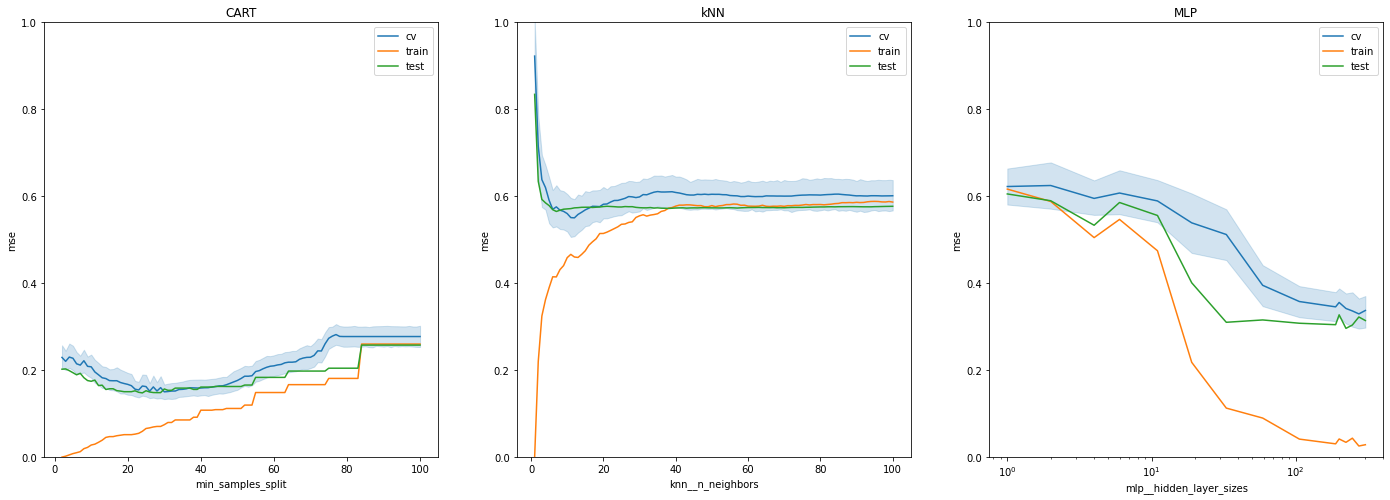

In [19]:
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

print("Dummy Regressor, mean CV MSE={}, test MSE={}".format(dr_stats['mse'].mean(), mean_squared_error(y_test, drcv.predict(X_test))))
print("CART, best CV MSE={}, test MSE={}".format(CARTcv.best_score_, mean_squared_error(y_test, CARTcv.predict(X_test))))
print("kNN, best CV MSE={}, test MSE={}".format(knncv.best_score_, mean_squared_error(y_test, knncv.predict(X_test))))
print("MLP, best CV MSE={}, test MSE={}".format(mlpcv.best_score_, mean_squared_error(y_test, mlpcv.predict(X_test))))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))

sns.lineplot(data=CART_stats, x='min_samples_split', y='mse', label='cv', ax=axs[0]);
sns.lineplot(data=CART_train_test, x='min_samples_split', y='train', label='train', ax=axs[0])
sns.lineplot(data=CART_train_test, x='min_samples_split', y='test', label='test', ax=axs[0])
axs[0].set_ylim((0, 1))
axs[0].set_title('CART')

sns.lineplot(data=knn_stats, x='knn__n_neighbors', y='mse', label='cv', ax=axs[1]);
sns.lineplot(data=knn_train_test, x='knn__n_neighbors', y='train', label='train', ax=axs[1])
sns.lineplot(data=knn_train_test, x='knn__n_neighbors', y='test', label='test', ax=axs[1])
axs[1].set_ylim((0, 1))
axs[1].set_title('kNN')

sns.lineplot(data=mlp_stats, x='mlp__hidden_layer_sizes', y='mse', label='cv', ax=axs[2]);
sns.lineplot(data=mlp_train_test, x='mlp__hidden_layer_sizes', y='train', label='train', ax=axs[2])
sns.lineplot(data=mlp_train_test, x='mlp__hidden_layer_sizes', y='test', label='test', ax=axs[2])
axs[2].set_ylim((0, 1))
axs[2].set_title('MLP')
axs[2].set_xscale('log');

**TASK 3:** Comment on the relative performance of the learning algorithms, paying attention to:
1. The relationship between testing error and cross validation error;
2. The suitability of the cross validation error for selecting hyperparameter settings; and
3. The ranking of the learning methods.

**ANSWERS**
1. The testing error and the cross validation error is relatively strongly related, as both lines follow a similar pattern and are quite close to each other. However, the testing error is below the cross validation most of the time.
2. The whole data set is used to train and evaluate the model. While the train test split method only use a portion of the data to train and then use another portion of data to test the model.
3. The K-Nearest Neighbours learning model has the highest performance, then MLP and then CART.  

As with previous labs, we can plot the best tree produced by CART. For practice, examine the tree and see if you can understand its behaviour (e.g., what features are most prominent?)

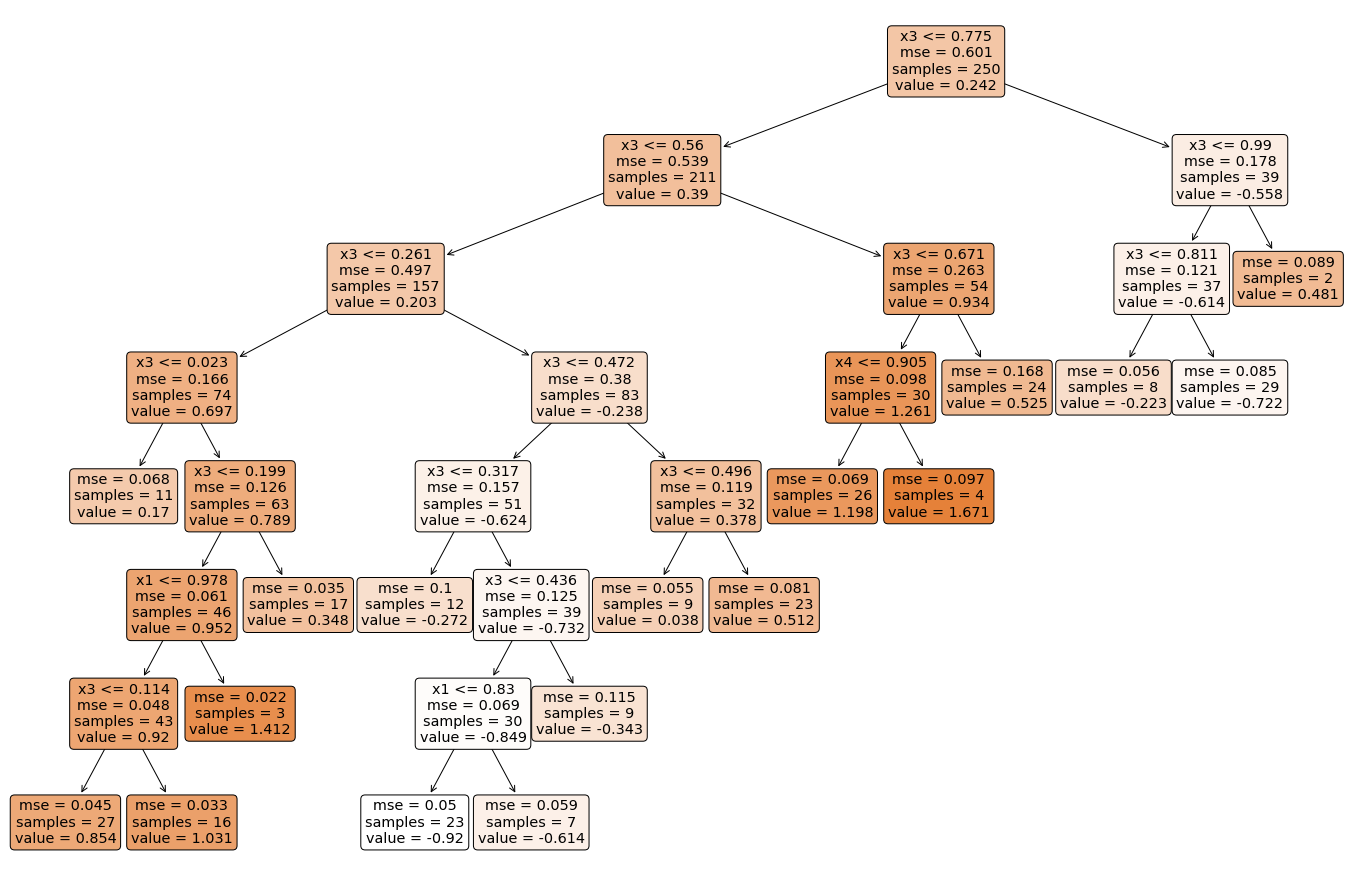

In [22]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

_ = plt.figure(figsize=(24, 16))
plot_tree(CARTcv.best_estimator_, rounded=True, filled=True, feature_names=[ 'x1', 'x2', 'x3', 'x4', 'x5', 'x6' ]);

## Classification

We now perform the same process, but this time for a classification target. As before, we will start by encapsulating the process of performing cross validation and extracting the resulting statistics into a single function:

In [26]:
def cross_validate_model_f1score(mdl, param_grid, X, y, cv=None):
    import numpy as np
    import pandas as pd

    from sklearn.metrics import f1_score, make_scorer
    from sklearn.model_selection import GridSearchCV
    
    ## create an F1 scorer to replace the default accuracy scorer. Given that the f1_score function
    ## allows for several different types of aggregation, and we want the macro F1 score, we supply
    ## the average='macro' parameter as part of the scorer's construction
    scorer = make_scorer(f1_score, average='macro')
    
    ## perform the grid search on the supplied data
    cv = GridSearchCV(mdl, param_grid, scoring=scorer, cv=cv)
    cv.fit(X, y)

    ## convert the cross validation results into a data frame, keeping only the
    ## hyperparameter columns and the scores from individual runs, then conver the data
    ## frame from wide to long (via melt). After this, clean up the column names and split
    ## information.
    cv_stats = pd.DataFrame(cv.cv_results_).filter(regex='(param_.*)|(split.*_test_score)', axis=1)
    cv_stats = cv_stats.melt(id_vars=cv_stats.columns[cv_stats.columns.str.match('param_.*')], var_name='split', value_name='macro_f1')
    cv_stats.rename(columns=lambda n: n.replace('param_', ''), inplace=True)
    cv_stats['split'] = cv_stats['split'].str.replace('split(\d+)_test_score', '\\1', regex=True).astype(np.int64)
    
    return cv, cv_stats

**TASK 4:** Compare the above function to the <code>cross_validate_model_mse</code> defined earlier - briefly comment on their differences, and suggest a potential way to combine the two into one function

Both function basicalliy does the same thing - perform a cross validation and hyperparameter tunning. However, the first function regression and the function above is for classification. Therefore the only differences between the two functions is scorer - how the perforamnce of the models are measured. The first function, since it is for regression, it uses MSE (mean_squared_error) to measure the performance of the model while the function above uses Macro F1 score (f1_score), because it it for classification. To combine the two functions together, we will need to implement some kind of logit that we determine the type of performance metric base on the input model.

We now load the required classification data - in this case we will use the well-known [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). This is a relatively simple data set, but is sufficient for demonstration here

In [27]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X, y = cancer['data'], cancer['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1234)
print(X.shape)

(569, 30)


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

dc = DummyClassifier(strategy='most_frequent')
dc_grid = {}

CART = DecisionTreeClassifier()
CART_grid = { 'min_samples_split' : [ i for i in range(2, 51) ] }

zknn = Pipeline([ ('scale', StandardScaler()), ('knn', KNeighborsClassifier()) ])
zknn_grid = { 'knn__n_neighbors' : [ i for i in range(1, 101) ] }

nnet = Pipeline([ ('scale', StandardScaler()), ('mlp', MLPClassifier(max_iter=10000)) ])
nnet_grid = { 'mlp__hidden_layer_sizes' : [ 1, 2, 5, 10, 14, 28, 42 ] }

dccv, dc_stats = cross_validate_model_f1score(dc, dc_grid, X_train, y_train, cv=rkf)
CARTcv, CART_stats = cross_validate_model_f1score(CART, CART_grid, X_train, y_train, cv=rkf)
knncv, knn_stats = cross_validate_model_f1score(zknn, zknn_grid, X_train, y_train, cv=rkf)
mlpcv, mlp_stats = cross_validate_model_f1score(nnet, nnet_grid, X_train, y_train, cv=rkf)

Assuming that the previous cell executed correctly, then you should be able to print out the performance statistics of the classification methods below:

In [29]:
from sklearn.metrics import f1_score

print("Dummy Classifier, macro F1={}, test macro F1={}".format(dc_stats['macro_f1'].mean(), f1_score(y_test, dccv.predict(X_test))))
print("CART, best CV macro F1={}, test macro F1={}".format(CARTcv.best_score_, f1_score(y_test, CARTcv.predict(X_test))))
print("kNN, best CV macro F1={}, test macro F1={}".format(knncv.best_score_, f1_score(y_test, knncv.predict(X_test))))
print("MLP, best CV macro F1={}, test macro F1={}".format(mlpcv.best_score_, f1_score(y_test, mlpcv.predict(X_test))))

Dummy Classifier, macro F1=0.3837774277478147, test macro F1=0.7725321888412017
CART, best CV macro F1=0.9217592572611988, test macro F1=0.9569892473118279
kNN, best CV macro F1=0.9694054649894029, test macro F1=0.9782608695652174
MLP, best CV macro F1=0.966047017514547, test macro F1=0.9836065573770492


Assuming that the previous cell executed correctly, then you should be able to plot the results below.

**TASK 5:** Plot the results of the three learning algorithms (use the example from the regression exercise to help you here)

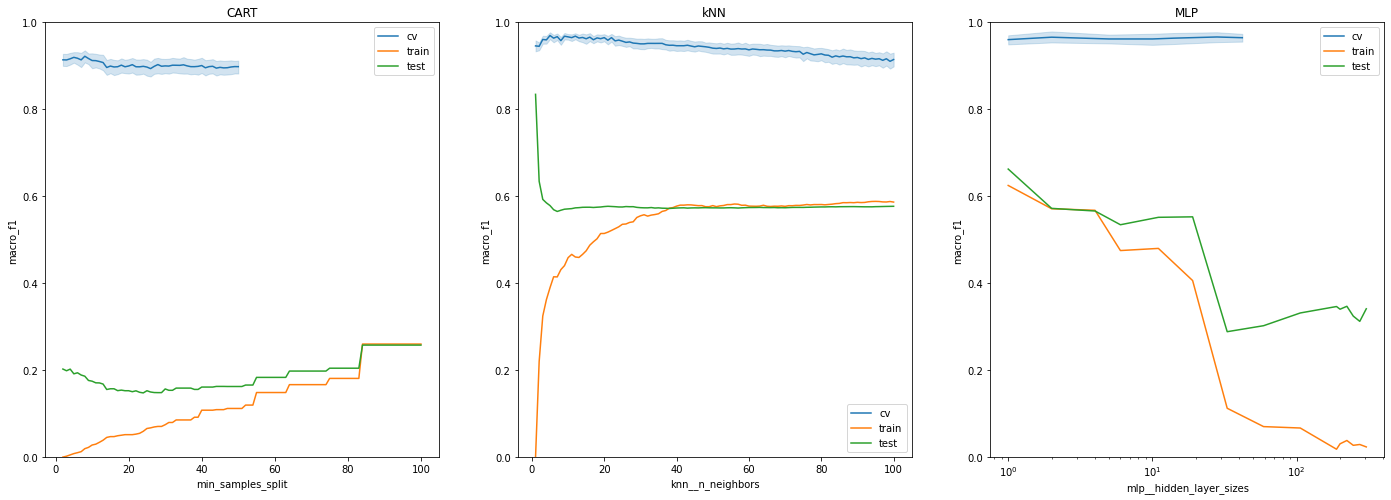

In [30]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))

sns.lineplot(data=CART_stats, x='min_samples_split', y='macro_f1', label='cv', ax=axs[0]);
sns.lineplot(data=CART_train_test, x='min_samples_split', y='train', label='train', ax=axs[0])
sns.lineplot(data=CART_train_test, x='min_samples_split', y='test', label='test', ax=axs[0])
axs[0].set_ylim((0, 1))
axs[0].set_title('CART')

sns.lineplot(data=knn_stats, x='knn__n_neighbors', y='macro_f1', label='cv', ax=axs[1]);
sns.lineplot(data=knn_train_test, x='knn__n_neighbors', y='train', label='train', ax=axs[1])
sns.lineplot(data=knn_train_test, x='knn__n_neighbors', y='test', label='test', ax=axs[1])
axs[1].set_ylim((0, 1))
axs[1].set_title('kNN')

sns.lineplot(data=mlp_stats, x='mlp__hidden_layer_sizes', y='macro_f1', label='cv', ax=axs[2]);
sns.lineplot(data=mlp_train_test, x='mlp__hidden_layer_sizes', y='train', label='train', ax=axs[2])
sns.lineplot(data=mlp_train_test, x='mlp__hidden_layer_sizes', y='test', label='test', ax=axs[2])
axs[2].set_ylim((0, 1))
axs[2].set_title('MLP')
axs[2].set_xscale('log');

**TASK 6:** Comment on the relative performance of the learning algorithms, paying attention to the ranking of the learning methods. You should compare these results to the results of the regression problem (e.g., what are the relative rankings of the methods?).

_WRITE YOUR ANSWER HERE_

## Neural Network Hyperparameters

So far, you've incorporated a neural network into several steps of this lab. However, you haven't really had a chance to stop and consider the hyperparameters available to help establish and train a neural network. In this section, you will consider three important hyperparameters:
 * the number of nodes in the single hidden layer (we won't explore multiple hidden layers here) - increasing this value increases the "capacity" of the network, which my potentially allow it to fit to the training data better;
 * the regularisation parameter <code>alpha</code> - larger values impose a restriction on the neural network and limit its ability to fit the training data. Under the right conditions (e.g., noisy data), this hyperparameter will help to control overfitting; and
 * the activation function (one of 'tanh', 'relu', or 'identity') - the identity performs no activation (i.e., the output of a node is its weighted sum of its inputs), which the other two should be somewhat self-explanatory.
 
You will also examine the importance of training set size on neural network performance. Ultimately, you will use data from runs exploring these variables to produce a plot of behaviour (error against the three hyperparameters and training set size) and deduce from this plot the conditions under which you'd expect a neural network to behave well.

For this part of the lab, you are required to implement a procedure that will construct and fit a neural network under a range of hyperparameter settings. There are many ways to do this, but perhaps the simplest way (conceptually, at least) is as follows:
<ol>
    <li>Create an empty list, called <code>mlp_res</code></li>
    <li>For every item in a declared a list of training set sizes:&nbsp;&nbsp;(n_train)
        <ol>
            <li>Use the <code>make_friedman1</code> function to make a training data set (X_train, y_train)</li>
            <li>For every item in a declared a list of hidden layer sizes:&nbsp;&nbsp;(n_hid)
                <ol>
                    <li>For every item in a declared list of regularisation factors:&nbsp;&nbsp;(alpha)
                        <ol>
                            <li>For every item in a declared list of activation functions:&nbsp;&nbsp;(act)
                                <ol>
                                    <li>Construct a <code>MLPRegressor</code> object using the specified hidden layer size, regularisation factor and activation function</li>
                                    <li>Fit the neural network to the training data</li>
                                    <li>Use the neural network to obtain predictions for the test data instances</li>
                                    <li>Compute the mean squared error of the test predictions&nbsp;&nbsp;(mse)</li>
                                    <li>Append to <code>mlp_res</code> the tuple: (n_train, n_hid, alpha, act, mse)</li>
                                </ol>
                            </li>
                        </ol>
                    </li>
                </ol>
            </li>
            <li>Construct a <code>LinearRegressor</code>; it to the training data, and compute its test mse</li>
            <li>Construct a <code>DummyRegressor</code> object, &quot;fit&quot; it to the training data, and compute its test mse</li>
            <li>Print out the mean squared errror of both methods on the test data</li>
        </ol>
    </li>
</ol>

Note that the amount of nested for loops required to implement this can be greatly reduced by using the [product](https://docs.python.org/3/library/itertools.html#itertools.product) functionality of the [itertools](https://docs.python.org/3/library/itertools.html) library and specifying the hyperparameters in a tuning grid.

The [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) documentation will be helpful here, as will the earlier examples in this lab. Consider the following lists of values for the hyperparameters:
  * n_train : \[ 50, 100, 250, 500 \]
  * n_hid : \[ 1, 10, 100 \]
  * alpha : \[ 0.0, 0.1, 1.0, 10 \]
  * act : \[ 'identity', 'tanh', 'relu' \]

**TASK 7:** Implement the procedure outlined above to produce a list called <code>mlp_res</code> that contains the required error performance for the various neural network runs.

In [33]:
import pandas as pd

from itertools import product

from sklearn.datasets import make_friedman1

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

X_test, y_test = make_friedman1(n_samples=6000, noise=1)
n_trains = [ 50, 100, 250, 500 ]
n_hids = [ 1, 10, 100 ]
alphas = [ 0.0, 0.1, 1.0, 10 ]
acts = [ 'identity', 'tanh', 'relu' ]
mpl_res = []
for n_train in n_trains:
    X_train, y_train = make_friedman1(n_samples=training_size, random_state=1234)
    for n_hid in n_hids:
        for alpha in alphas:
            for act in acts:
                nnet = MLPRegressor(n_hid=n_hid, alha=alpha, act=act)
                nnet.fit(X_train, y_train)
                y_pred = nnet.predict(x_test)
                mse = mean_squared_error(y_test, y_pred)
                mpl_res.append((n_train, n_hid, alpha, act, mse))
    lm = LinearRegressor()
    lm.fit(X_train, y_train)
    lm_mse = mean_squared_error(y_test, lm.predict(X_test))
    dr = DummyRegressor()
    dr.fit(X_train, y_train)
    dr_mse
        
    
    


In [ ]:
import seaborn as sns

g = sns.FacetGrid(mlp_res, col='alpha', row='n_train', hue='activation', margin_titles=True)
g.map(sns.lineplot, 'n_hidden', 'mse')
g.add_legend();

mlp_res[(mlp_res['alpha']==0) & (mlp_res['activation']=='identity')]

Using this graph, answer the following:

**TASK 8:** Based on the results shown in the graph, briefly comment on what happes to the neural network behaviour when the activation argument is set to 'identity'. Also, provide a brief description of a neural network's performance on data in response to the hyperparameter settings and data we ave used.

_WRITE YOUR ANSWER HERE_

## The End

You've reached the end of the lab. Be sure to save and upload your work to Blackboard before the due date. ***Assuming that there is time remaining in the lab, you should use this time to work on the first assignment.***